# Predicting heart disease using a patient’s age, maximum heart rate, ST depression, and thalassemia
## Introduction
Given our preliminary data exploration conducted with this data set, we chose to use 4 variables in order to build a classifier that will be designed to predict whether or not a patient has heart disease given these 4 variables:
* Maximum heart rate achieved by the patient (bpm)
* Age of patient
* Status of the patient's thalassemia (a blood disorder)
* ST depression (measured by ECG)
These variables were chosen as they were found to have some sort of association with our response variable (diagnosis). The question we are trying to answer with this predictive data analysis is, given the stated variables, does that person have heart disease?
## Methods

In [1]:
library(tidyverse)
library(tidymodels)
set.seed(54321)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
heart_temp <- tempfile()
download.file(url, heart_temp)
data <- read_csv(unzip(heart_temp, "processed.cleveland.data"), col_names = FALSE, show_col_types = FALSE) |>
    rename(age = X1, sex = X2, chest_pain = X3, resting_blood_pressure = X4,
           cholesterol = X5, fasting_blood_sugar = X6,
           resting_ecg = X7, max_heart_rate = X8, exercise_angina = X9,
           st_depression = X10, slope = X11, major_vessels = X12, thal = X13,
           diagnosis = X14)
unlink(heart_temp)

In [3]:
data_selected <- data |>
    select(age, max_heart_rate, st_depression, thal, diagnosis) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    mutate(diagnosis = fct_recode(diagnosis, "1" = "2", "1" = "3", "1" = "4"))

glimpse(data_selected)

Rows: 303
Columns: 5
$ age            <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44,…
$ max_heart_rate <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 148, …
$ st_depression  <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.1, 0.4, …
$ thal           <chr> "6.0", "3.0", "7.0", "3.0", "3.0", "3.0", "3.0", "3.0",…
$ diagnosis      <fct> 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0…


One issue that was found during our preliminary data analysis was that there are some rows with missing values for the `thal` variable. To be able to easily ignore these values, the below code will convert them to `NA` in R:

In [4]:
data_selected <- mutate(data_selected, thal = if_else(thal == "?", NA, thal)) |>
    mutate(thal = as.numeric(thal))

Now we can split the data set (and easily drop NA values) into a training set, which will be used to build our classifier, and a testing set, which will be used to evaluate the classifier.

In [5]:
data_split <- data_selected |>
    drop_na() |>
    mutate(diagnosis = fct_recode(diagnosis,
                                "Angiographic disease" = "1",
                                "Healthy" = "0")) |>
    initial_split(prop = 0.75, strata = diagnosis)

training_set <- training(data_split)
testing_set <- testing(data_split)

Now we will use cross-validation with 10 folds to determine the best K value to use for our K-nearest-neighbours classifier.

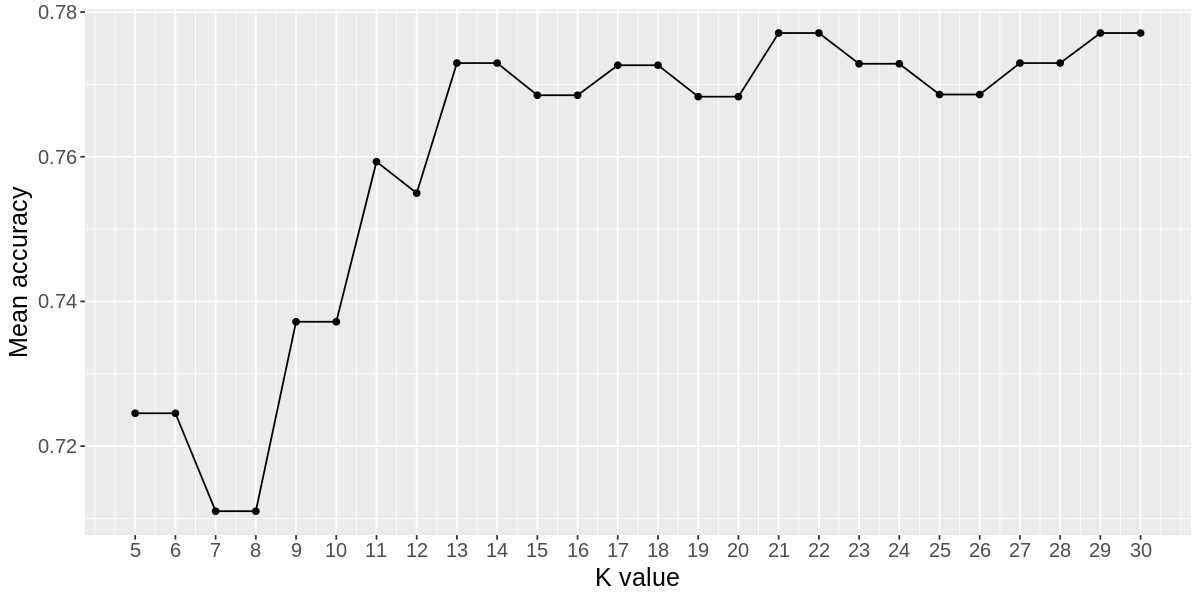

In [6]:
set.seed(54321)
knn_recipe <- recipe(diagnosis ~ ., data = training_set) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = 5:30)

vfold <- vfold_cv(training_set, v = 5, strata = diagnosis)

knn_fit_tuning <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec_tune) |>
    tune_grid(resamples = vfold, grid = k_vals)

tuning_metrics <- knn_fit_tuning |>
    collect_metrics()

tuning_accuracies <- filter(tuning_metrics, .metric == "accuracy")

cross_val_plot <- tuning_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() +
    labs(x = "K value", y = "Mean accuracy") +
    theme(text = element_text(size = 15)) +
    scale_x_continuous(breaks = 5:30)

options(repr.plot.height = 5, repr.plot.width = 10)
cross_val_plot

From the above graph, we choose K to be 30 for the rest of our classifier.

In [7]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = training_set)

In [8]:
predictions <- predict(knn_fit, testing_set) |>
    bind_cols(testing_set)

metrics <- predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

conf_mat <- predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)

metrics
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7763158


                      Truth
Prediction             Healthy Angiographic disease
  Healthy                   31                    7
  Angiographic disease      10                   28

Since we are particularly interested in classifying and identifying patients with heart disease, we set this as our "important"/"positive" class when calculating precision and recall below:

In [10]:
# precision = true positives / all positive predictions
# a.k.a.
# true positives / (true positive + false positive)

precision = 28 / (28 + 10)

# recall = true positives / # of positive test data points
# a.k.a.
# true positives / (true positive + false negative)

recall = 28 / (28 + 7)

precision
recall

[1] 0.7368421

[1] 0.8